In [157]:
import stataccess as stacc
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

Problem: The overall card evaulation stats on 17lands, game played win rate (GPWR) and game in hand win rate (GIHWR) both have significant sources of bias. Game played win rate is as much a function of the decks that a card is typically put in as it is the quality of a given card. Game in hand win rate has less of that bias by only counting games where the card shows up (though deck quality bias is still present). The downside is that it oversamples longer games, because the more cards are drawn, the more likely any particular card shows up. This causes cards that tend to win long games and lose short ones to have inflated values of GIHWR, and vice versa.

Idea: Try average win shares (AWS) as an evaluation metric. Each game has a value of +/-1 depending on whether it was a win or loss. That is divided evenly among all cards that appear in the game. For each card, this quantity is then averaged over each time the card appears in a game.
Win shares is intended to be analogous to GIHWR, but each game is weighted inversely proportional to how likely a card is to show up in it, which should cancel out the oversampling.

Note: If r=GIHWR, and there were exactly 15 cards drawn every game, AWS=r/15-(1-r)/15=1/15(2r-1). We can expect AWS and GIHWR to be highly correlated.


In [158]:
main_colors='ALL'
wsDF=stacc.getAverageWinShares(main_colors=main_colors,set_abbr='ltr',as_json=False)
gihDF=stacc.getGameInHandWR(main_colors=main_colors,set_abbr='ltr',as_json=False)
cardDF=stacc.cardInfo(set_abbr='ltr')
gpwrDF=stacc.getCardInDeckWinRates(archLabel=main_colors,set_abbr='ltr',as_json=False)
gpwrDF.index=gpwrDF['id']
gpwrDF.sort_index(inplace=True)
wsDF.sort_index(inplace=True)
gihDF.sort_index(inplace=True)

In [159]:
def colorWord(colorInt:int):
    match colorInt:
        case 0: return 'brown'
        case 1: return 'gray'
        case 2: return 'blue'
        case 4: return 'black'
        case 8: return 'red'
        case 16: return 'green'
        case _: return 'gold'
data=pd.DataFrame({'gihwr':gihDF['win_rate'],'win_shares':wsDF['avg_win_shares'],'games':gihDF['games_in_hand'],'gpwr':gpwrDF['win_rate'],
                   'color':[colorWord(cardDF.at[idx,'color']) for idx in gihDF.index],'mv':10*cardDF['mana_value']+10},index=gihDF.index)
data.sort_values('games',ascending=False,inplace=True)
print(data.head())

            gihwr  win_shares   games      gpwr  color  mv
card_id                                                   
266      0.567666    0.006678  576013  0.559965  brown   0
268      0.568632    0.006382  550050  0.560653  brown   0
264      0.550761    0.003906  432503  0.545049  brown   0
262      0.550323    0.004433  352769  0.542979  brown   0
270      0.532241    0.002051  228160  0.525956  brown   0


In [160]:
gihwr=data['gihwr'][:250].values.reshape(-1,1)
ws=data['win_shares'][:250].values.reshape(-1,1)
reg=LinearRegression().fit(gihwr,ws)
m1=reg.coef_[0,0]
b1=reg.intercept_[0]
print('r-squared:',reg.score(gihwr,ws))
print('y=',m1,'x+',b1)

r-squared: 0.9442879697733868
y= 0.1261414233953682 x+ -0.0652061376342713


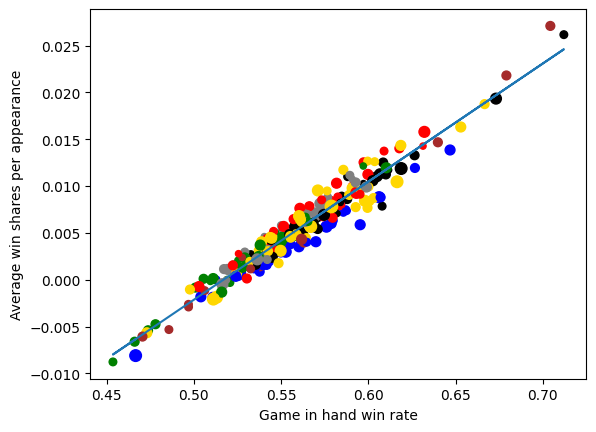

In [161]:
plt.scatter('gihwr','win_shares',c='color',s='mv',data=data.iloc[:250,:])
plt.xlabel('Game in hand win rate')
plt.ylabel('Average win shares per appearance')
plt.plot(gihwr,m1*gihwr+b1)
plt.show()

As expected we see a close correlation. Also, we can see blue cards, which tend to have win rates positively correlated with number of cards drawn below the line, indicating that they are favored by GIHWR more than AWS. Likewise red cards, which typically have the opposite correlation are above the line. 

In [162]:
gpwr=data['gpwr'][:250].values.reshape(-1,1)
reg=LinearRegression().fit(gpwr,gihwr)
print('r-squared:',reg.score(gpwr,gihwr))
m2=reg.coef_[0,0]
b2=reg.intercept_[0]
print('y=',m2,'x+',b2)

r-squared: 0.8111035416502119
y= 1.3917087592650565 x+ -0.194803807096937


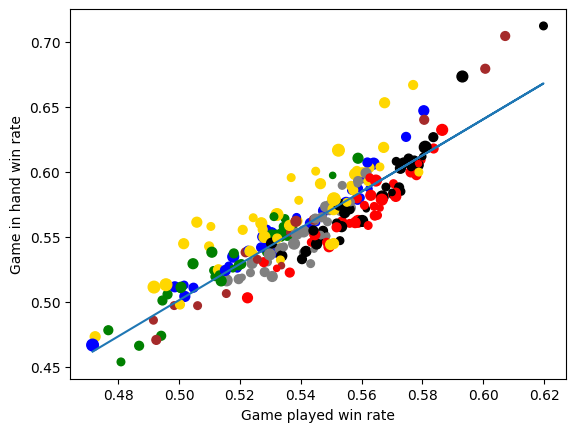

In [163]:
plt.scatter('gpwr','gihwr',c='color',s='mv',data=data.iloc[:250,:])
plt.xlabel('Game played win rate')
plt.ylabel('Game in hand win rate')
plt.plot(gpwr,m2*gpwr+b2)
plt.show()

The GIHWR bias against red and in favor of blue is also visible here.

In [164]:
reg=LinearRegression().fit(gpwr,ws)
print('r-squared:',reg.score(gpwr,ws))
m3=reg.coef_[0,0]
b3=reg.intercept_[0]
print('y=',m3,'x+',b3)

r-squared: 0.8036217500667067
y= 0.1798214734412327 x+ -0.09209626688026594


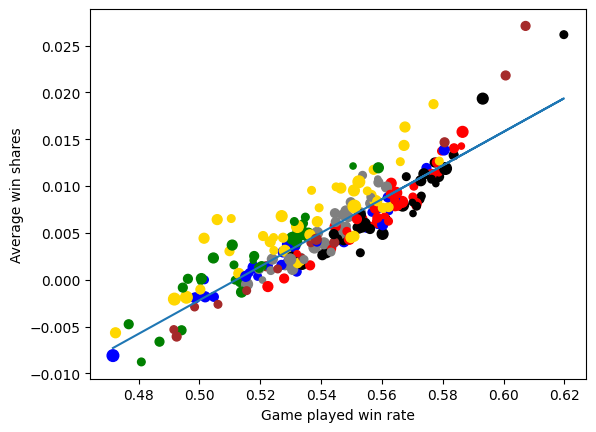

In [165]:
plt.scatter('gpwr','win_shares',c='color',s='mv',data=data.iloc[:250,:])
plt.xlabel('Game played win rate')
plt.ylabel('Average win shares')
plt.plot(gpwr,m3*gpwr+b3)
plt.show()

With AWS replacing GIHWR, the bias by color appears to be less extreme, but the correlation to GPWR isn't any better. GPWR has a large contribution from average deck quality, so it may be helpful to narrow down to comparing a specific color pair to lessen the contribution of this factor.

In [166]:
main_colors='WU'
wsDF=stacc.getAverageWinShares(main_colors=main_colors,set_abbr='ltr',as_json=False)
gihDF=stacc.getGameInHandWR(main_colors=main_colors,set_abbr='ltr',as_json=False)
cardDF=stacc.cardInfo(set_abbr='ltr')
gpwrDF=stacc.getCardInDeckWinRates(archLabel=main_colors,set_abbr='ltr',as_json=False)
gpwrDF.index=gpwrDF['id']
gpwrDF.sort_index(inplace=True)
wsDF.sort_index(inplace=True)
gihDF.sort_index(inplace=True)
data=pd.DataFrame({'gihwr':gihDF['win_rate'],'win_shares':wsDF['avg_win_shares'],'games':gihDF['games_in_hand'],'gpwr':gpwrDF['win_rate'],
                   'color':[colorWord(cardDF.at[idx,'color']) for idx in gihDF.index],'mv':10*cardDF['mana_value']+10},index=gihDF.index)
data.sort_values('games',ascending=False,inplace=True)

In [167]:
gihwr=data['gihwr'][:50].values.reshape(-1,1)
ws=data['win_shares'][:50].values.reshape(-1,1)
reg=LinearRegression().fit(gihwr,ws)
m1=reg.coef_[0,0]
b1=reg.intercept_[0]
print('r-squared:',reg.score(gihwr,ws))
print('y=',m1,'x+',b1)

r-squared: 0.9695270728435839
y= 0.11925257420743166 x+ -0.06254516971213499


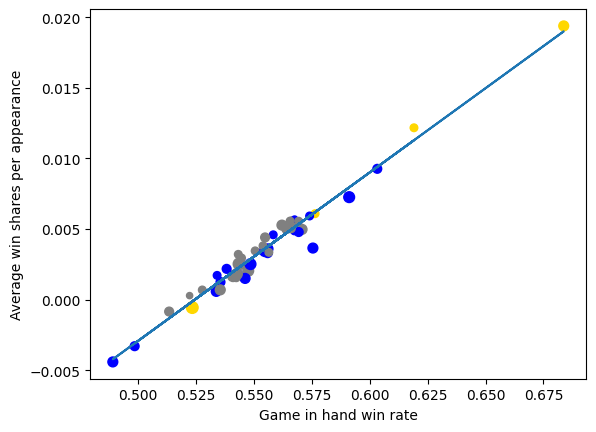

In [168]:
plt.scatter('gihwr','win_shares',c='color',s='mv',data=data.iloc[:50,:])
plt.xlabel('Game in hand win rate')
plt.ylabel('Average win shares per appearance')
plt.plot(gihwr,m1*gihwr+b1)
plt.show()

In [169]:
gpwr=data['gpwr'][:50].values.reshape(-1,1)
reg=LinearRegression().fit(gpwr,gihwr)
print('r-squared:',reg.score(gpwr,gihwr))
m2=reg.coef_[0,0]
b2=reg.intercept_[0]
print('y=',m2,'x+',b2)

r-squared: 0.8545547121964956
y= 1.7554226266798316 x+ -0.3715620728939333


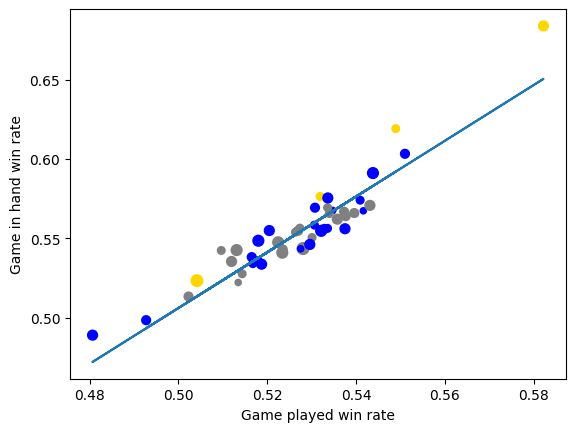

In [170]:
plt.scatter('gpwr','gihwr',c='color',s='mv',data=data.iloc[:50,:])
plt.xlabel('Game played win rate')
plt.ylabel('Game in hand win rate')
plt.plot(gpwr,m2*gpwr+b2)
plt.show()

In [171]:
reg=LinearRegression().fit(gpwr,ws)
print('r-squared:',reg.score(gpwr,ws))
m3=reg.coef_[0,0]
b3=reg.intercept_[0]
print('y=',m3,'x+',b3)

r-squared: 0.8525790964491939
y= 0.21235714978344575 x+ -0.10844641703878587


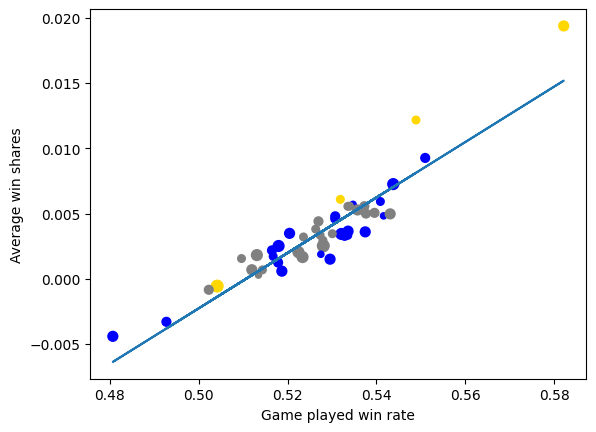

In [172]:
plt.scatter('gpwr','win_shares',c='color',s='mv',data=data.iloc[:50,:])
plt.xlabel('Game played win rate')
plt.ylabel('Average win shares')
plt.plot(gpwr,m3*gpwr+b3)
plt.show()

There doesn't seem to be a particularly substantial difference between AWS and GIHWR. Unless some other evaluation suggests significant merit for AWS, the relative simplicity of GIHWR over AWS makes it preferable.